In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

In [3]:
import os

# move to project root
while True:
    # get list of directories
    dirs = os.listdir()
    if "README.md" in dirs:
        break
    else:
        os.chdir("..")
print(os.getcwd())

/mnt/raid/bling/bram/multilang_timescale


In [4]:
import json

from typing import Dict, Literal

import numpy as np

from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import seaborn as sns

import cortex

from src.settings import TrainerSetting

from src.utils.utils import get_surface_dict, put_values_on_mask
from src.utils.meta import read_result_meta

from src.utils.plot import (
    config_plotting,
    figsize_dict,
    get_timescale_scalar_mappable,
    plot_timescale_selectivity,
    plot_timescale_flatmap_from_volume,
    id_to_label
)

from src.utils.utils import (
    timescale_permutation_test, 
)

from src.utils.weight import process_primal_weight

In [5]:
result_meta_dir = ".temp/result_meta/bling"

result_metric = "r2"

alpha = 0.05

plotting_context = "paper"

analysis_name = "timescale_selectivity"

figsize_type = "half"

is_log = False
is_symmetric = False
is_alpha_mask = False

diff_max_val = 128

In [6]:
subject_ids = ["COL", "GFW", "TYE"]

config_plotting(context=plotting_context)

figsize = figsize_dict[figsize_type]
# get default font size
default_font_size = plt.rcParams["font.size"]


In [7]:
def get_stats(subject_id: str):
    en_feature_config = f".temp/config/bling/feature/{subject_id}/mBERT_all_untrimmed_timescale_stepwise_en.json"
    zh_feature_config = f".temp/config/bling/feature/{subject_id}/mBERT_all_untrimmed_timescale_stepwise_zh.json"

    en_trainer_config = (
        f".temp/config/bling/train/stepwise/{subject_id.lower()}_en_timescale.json"
    )
    zh_trainer_config = (
        f".temp/config/bling/train/stepwise/{subject_id.lower()}_zh_timescale.json"
    )

    en_subject_config = f".temp/config/bling/subject/{subject_id}_en.json"
    zh_subject_config = f".temp/config/bling/subject/{subject_id}_zh.json"

    en_meta_df = read_result_meta(
        result_meta_dir,
        trainer_setting_path=en_trainer_config,
        subject_setting_path=en_subject_config,
        feature_setting_path=en_feature_config,
    )

    zh_meta_df = read_result_meta(
        result_meta_dir,
        trainer_setting_path=zh_trainer_config,
        subject_setting_path=zh_subject_config,
        feature_setting_path=zh_feature_config,
    )

    en_config = en_meta_df.iloc[0].to_dict()
    zh_config = zh_meta_df.iloc[0].to_dict()

    # loading stats
    en_stat = en_config["stats_path"]
    en_stat = np.load(en_stat)

    zh_stat = zh_config["stats_path"]
    zh_stat = np.load(zh_stat)

    keyword = f"test_{result_metric}_selectivity_mask"
    p_val_keyword = f"test_p_values_{result_metric}_mask"

    # en_timescale = get_valid_result(en_stat, keyword, metric=result_metric, alpha=alpha)
    # zh_timescale = get_valid_result(zh_stat, keyword, metric=result_metric, alpha=alpha)

    en_timescale, _ = put_values_on_mask(
        en_stat[keyword],
        en_stat[p_val_keyword],
        alpha=alpha,
    )

    zh_timescale, _ = put_values_on_mask(
        zh_stat[keyword],
        zh_stat[p_val_keyword],
        alpha=alpha,
    )

    diff_timescale = en_timescale - zh_timescale

    keyword = f"test_joint_{result_metric}_score_mask"

    en_score, _ = put_values_on_mask(
        en_stat[keyword],
        en_stat[p_val_keyword],
        alpha=alpha,
        valid_range=(0, 1),
    )

    zh_score, _ = put_values_on_mask(
        zh_stat[keyword],
        zh_stat[p_val_keyword],
        alpha=alpha,
        valid_range=(0, 1),
    )

    if result_metric == "r2":
        en_score = np.maximum(0, np.sqrt(en_score))
        zh_score = np.maximum(0, np.sqrt(zh_score))

    return {
        "timescale": {
            "en": en_timescale,
            "zh": zh_timescale,
            "diff": diff_timescale,
        },
        "score": {
            "en": en_score,
            "zh": zh_score,
        },
    }

In [8]:
stats = {}

for id in subject_ids:
    stats[id] = get_stats(id)

In [40]:
def plot_density(
    stats: Dict,
    result_metric: Literal["r", "r2"] = "r2",
    subject_id="COL",
    pred_score_filter: float = 0.0,
    top_score_percentage_filter: float = 0.0,
    figsize_type: Literal["half", "full"] = "half",
    is_histogram: bool = False,
    axs=None,
    set_lim: bool = True,
    print_x_label: bool = True,
):
    if axs is None:
        fig, axs = plt.subplots(1, 2, figsize=figsize_dict[figsize_type], sharey=True)

    result_type = "timescale"

    en_stat = stats[subject_id][result_type]["en"]
    zh_stat = stats[subject_id][result_type]["zh"]

    en_pred_mask = stats[subject_id]["score"]["en"] > pred_score_filter
    zh_pred_mask = stats[subject_id]["score"]["zh"] > pred_score_filter

    # compute top score mask
    non_nan_score_en = stats[subject_id]["score"]["en"][
        ~np.isnan(stats[subject_id]["score"]["en"])
    ]
    non_nan_score_zh = stats[subject_id]["score"]["zh"][
        ~np.isnan(stats[subject_id]["score"]["zh"])
    ]

    en_quantile = np.quantile(non_nan_score_en, top_score_percentage_filter)
    zh_quantile = np.quantile(non_nan_score_zh, top_score_percentage_filter)

    joint_quantile = np.minimum(en_quantile, zh_quantile)

    # print(f"EN Quantile: {en_quantile}")
    # print(f"ZH Quantile: {zh_quantile}")
    # print(f"Joint Quantile: {joint_quantile}")

    en_top_score_mask = stats[subject_id]["score"]["en"] > joint_quantile
    zh_top_score_mask = stats[subject_id]["score"]["zh"] > joint_quantile

    joint_mask = en_pred_mask & zh_pred_mask & en_top_score_mask & zh_top_score_mask

    en_stat = en_stat[joint_mask]
    zh_stat = zh_stat[joint_mask]

    pval, _ = timescale_permutation_test(en_stat, zh_stat)
    print(f"Permutation Test P-Value: {pval}")

    diff = en_stat - zh_stat

    # axs = axs.flatten()

    # # plot density of both en_stat and zh_stat in one plot
    if is_histogram:
        sns.histplot(
            en_stat,
            color="blue",
            label="EN",
            ax=axs[0],
            stat="density",
            kde=True,
            binrange=(8, 256),
            bins=16,
        )
        sns.histplot(
            zh_stat,
            color="red",
            label="ZH",
            ax=axs[0],
            stat="density",
            kde=True,
            binrange=(8, 256),
            bins=16,
        )
        sns.histplot(
            diff,
            color="green",
            label="EN - ZH",
            ax=axs[1],
            stat="density",
            kde=True,
            binrange=(-128, 128),
            bins=16,
        )
    else:
        sns.kdeplot(en_stat, color="blue", label="EN", fill=True, ax=axs[0])
        sns.kdeplot(zh_stat, color="red", label="ZH", fill=True, ax=axs[0])
        sns.kdeplot(diff, color="green", label="EN - ZH", fill=True, ax=axs[1])

    if print_x_label:
        axs[0].set_xlabel(f"Timescale Selectivity")
        axs[1].set_xlabel(f"Difference")

    # remove ylable for the right plot
    axs[1].set_ylabel("")
    # remove yticks for the right plot    
    # rotate yticklabels
    

    if set_lim:
        axs[0].set_xlim(0, 256)
        axs[1].set_xlim(-128, 128)

Permutation Test P-Value: 0.0
Permutation Test P-Value: 0.0
Permutation Test P-Value: 0.0


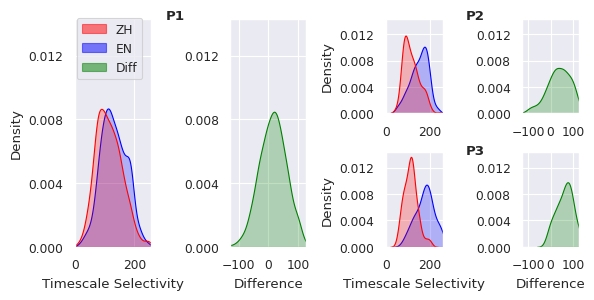

In [44]:
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches


fig = plt.figure(figsize=(6, 3))
gs = fig.add_gridspec(2, 4, width_ratios=[1, 1, 0.75, 0.75])

# two the big one for COL
ax_col_1 = fig.add_subplot(gs[:, 0])
ax_col_2 = fig.add_subplot(gs[:, 1], sharey=ax_col_1)

ax_gfw_1 = fig.add_subplot(gs[0, 2], sharex=ax_col_1, sharey=ax_col_1)
ax_gfw_2 = fig.add_subplot(gs[0, 3], sharex=ax_col_2, sharey=ax_col_1)

ax_tye_1 = fig.add_subplot(gs[1, 2], sharex=ax_col_1, sharey=ax_col_1)
ax_tye_2 = fig.add_subplot(
    gs[1, 3],
    sharex=ax_col_2,
    sharey=ax_col_1,
)

for ax in [ax_gfw_1, ax_gfw_2, ax_tye_1, ax_tye_2]:
    ax.yaxis.set_major_locator(ticker.MaxNLocator(4))


fig.text(
    0.3,
    0.9625,
    id_to_label["COL"],
    ha="center",
    va="center",
    fontsize=default_font_size,
    transform=fig.transFigure,  
    fontweight="bold",  
)
fig.text(
    0.8,
    0.9625,
    id_to_label["GFW"],
    ha="center",
    va="center",
    fontsize=default_font_size,
    transform=fig.transFigure,
    fontweight="bold",
)
fig.text(
    0.8,
    0.5125,
    id_to_label["TYE"],
    ha="center",
    va="center",
    fontsize=default_font_size,
    transform=fig.transFigure,
    fontweight="bold",
)

plot_density(
    stats, subject_id="COL", top_score_percentage_filter=0.75, axs=[ax_col_1, ax_col_2]
)

red_patch = mpatches.Patch(color="red", label="ZH", alpha=0.5)
blue_patch = mpatches.Patch(color="blue", label="EN", alpha=0.5)
green_patch = mpatches.Patch(color="green", label="Diff", alpha=0.5)
fig.legend(
    handles=[red_patch, blue_patch, green_patch],
    loc="upper left",
    bbox_to_anchor=(0.125, 0.975),
)

# smaller one for TYE and GFW

plot_density(
    stats,
    subject_id="GFW",
    top_score_percentage_filter=0.75,
    axs=[ax_gfw_1, ax_gfw_2],
    set_lim=False,
    print_x_label=False,
)
plot_density(
    stats,
    subject_id="TYE",
    top_score_percentage_filter=0.75,
    axs=[ax_tye_1, ax_tye_2],
    set_lim=False,
)

plt.tight_layout()

save_fn = f".temp/image/{analysis_name}/density_top25.png"

os.makedirs(os.path.dirname(save_fn), exist_ok=True)

plt.savefig(save_fn, dpi=300)


plt.show()

Permutation Test P-Value: 0.0
Permutation Test P-Value: 0.0
Permutation Test P-Value: 0.0


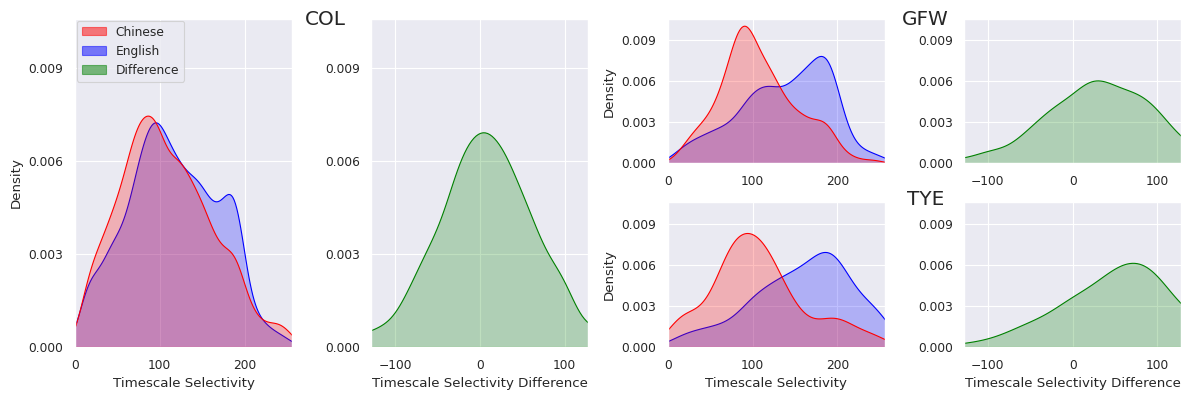

In [25]:
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches


fig = plt.figure(figsize=figsize_dict["double_half"])
gs = fig.add_gridspec(2, 4)

# two the big one for COL
ax_col_1 = fig.add_subplot(gs[:, 0])
ax_col_2 = fig.add_subplot(gs[:, 1], sharey=ax_col_1)

ax_gfw_1 = fig.add_subplot(gs[0, 2], sharex=ax_col_1, sharey=ax_col_1)
ax_gfw_2 = fig.add_subplot(gs[0, 3], sharex=ax_col_2, sharey=ax_col_1)

ax_tye_1 = fig.add_subplot(gs[1, 2], sharex=ax_col_1, sharey=ax_col_1)
ax_tye_2 = fig.add_subplot(
    gs[1, 3],
    sharex=ax_col_2,
    sharey=ax_col_1,
)

for ax in [ax_gfw_1, ax_gfw_2, ax_tye_1, ax_tye_2]:
    ax.yaxis.set_major_locator(ticker.MaxNLocator(4))


fig.text(
    0.275,
    0.9625,
    "COL",
    ha="center",
    va="center",
    fontsize=default_font_size * 1.5,
    transform=fig.transFigure,
)
fig.text(
    0.775,
    0.9625,
    "GFW",
    ha="center",
    va="center",
    fontsize=default_font_size * 1.5,
    transform=fig.transFigure,
)
fig.text(
    0.775,
    0.5125,
    "TYE",
    ha="center",
    va="center",
    fontsize=default_font_size * 1.5,
    transform=fig.transFigure,
)

plot_density(
    stats, subject_id="COL", top_score_percentage_filter=0, axs=[ax_col_1, ax_col_2]
)

red_patch = mpatches.Patch(color="red", label="Chinese", alpha=0.5)
blue_patch = mpatches.Patch(color="blue", label="English", alpha=0.5)
green_patch = mpatches.Patch(color="green", label="Difference", alpha=0.5)
fig.legend(
    handles=[red_patch, blue_patch, green_patch],
    loc="upper left",
    bbox_to_anchor=(0.0625, 0.975),
)

# smaller one for TYE and GFW

plot_density(
    stats,
    subject_id="GFW",
    top_score_percentage_filter=0,
    axs=[ax_gfw_1, ax_gfw_2],
    set_lim=False,
    print_x_label=False,
)
plot_density(
    stats,
    subject_id="TYE",
    top_score_percentage_filter=0,
    axs=[ax_tye_1, ax_tye_2],
    set_lim=False,
)

plt.tight_layout()

save_fn = f".temp/image/{analysis_name}/density_all.png"

os.makedirs(os.path.dirname(save_fn), exist_ok=True)

plt.savefig(save_fn, dpi=300)

plt.show()